In [1]:
## This script is to calculate the mean of RAINNC DA NODA and MRMS
## for 21-00, 00-03, 03-06, 18 total
## Created by C. Bayu Risanto, S.J. (3 October 2024)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from numpy import matlib
import xarray as xr
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mplotcolors
from matplotlib import cm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import date, datetime, timedelta
import glob
from os.path import exists
# create ncfile opener
def read_nx(ncfile):
    dx = xr.open_dataset(ncfile)
    r = dx.RAINNC[0,:,:]
    lat = dx.XLAT[0,:,:]
    lon = dx.XLONG[0,:,:]
    return r,lon,lat
def read_nx3(ncfile):
    dx = xr.open_dataset(ncfile)
    r = dx.RAINNC[0,:,:]
    return r
def read_mrms(link,ncfile):
    fname = link + ncfile
    ds = nc.Dataset(fname)
    pcp = ds.variables['PRECIP'][:,:,:]
    return pcp
def read_latlon_mrms(link,ncfile):
    fname = link + ncfile
    ds = nc.Dataset(fname)
    lat = ds.variables['lat_0'][:]
    lon = ds.variables['lon_0'][:]
    return lat,lon

In [2]:
## days of rain
DR = ['2021-07-03','2021-07-09','2021-07-10','2021-07-12','2021-07-13','2021-07-14',
      '2021-07-15','2021-07-16','2021-07-18','2021-07-21','2021-07-22','2021-07-23',
      '2021-07-24','2021-07-25','2021-07-29','2021-07-30','2021-08-10','2021-08-11',
      '2021-08-13','2021-08-15','2021-08-16','2021-08-30','2021-08-31','2021-09-01']

In [3]:
## make LIST of datetime string here
link_w = '/secchi/bayu/DATA/ARIZONA_PRO/DART_deterministic/'
datestrform = '%Y-%m-%dT%H'
R_EXP1 = []
R_EXP2 = []
for iday in range(len(DR)):
    date_st = datetime.strptime(DR[iday]+'T18',datestrform)
    DR_en = datetime.strptime(DR[iday],'%Y-%m-%d') + timedelta(days=1)
    date_en = datetime.strptime(DR_en.strftime('%Y-%m-%d')+'T12',datestrform)
    dateList = [date_st.strftime(datestrform)]
    date_time = date_st
    while date_time < date_en:
        date_time += timedelta(hours=1)
        dateList.append(date_time.strftime(datestrform))
    dateList = np.asarray(dateList)

## read data TOTAL RAINNC
    year = '2021'
    mont_st = str(dateList[0][5:7])
    day_st  = str(dateList[0][8:10])
    mont_en = str(dateList[-1][5:7])
    day_en  = str(dateList[-1][8:10])
    exp1 = year+mont_st+day_st+'_06Z_mc08_40mem_0035_6cyc_assim'
    exp2 = year+mont_st+day_st+'_06Z_mc08_40mem_0035_6cyc_noassim'
    f_st = 'wrfout_d02_'+year+'-'+mont_st+'-'+day_st+'_18:00:00'
    f_en = 'wrfout_d02_'+year+'-'+mont_en+'-'+day_en+'_12:00:00'
    r_exp1_st,xlon,xlat = read_nx(link_w+exp1+'/'+f_st)
    r_exp1_en,_,_       = read_nx(link_w+exp1+'/'+f_en)
    r_exp1 = r_exp1_en - r_exp1_st

    r_exp2_st,_,_       = read_nx(link_w+exp2+'/'+f_st)
    r_exp2_en,_,_       = read_nx(link_w+exp2+'/'+f_en)
    r_exp2 = r_exp2_en - r_exp2_st

## append
    R_EXP1.append(r_exp1); R_EXP2.append(r_exp2)
R_EXP1 = np.asarray(R_EXP1); R_EXP2 = np.asarray(R_EXP2)

In [5]:
## read MRMS hourly precip
linkMR = '/secchi/bayu/DATA/ARIZONA_PRO/OBS/MRMS/ncfiles/'
ACC_PCP = []
for iday in range(len(DR)):
    date_st = datetime.strptime(DR[iday]+'T18',datestrform)
    DR_en = datetime.strptime(DR[iday],'%Y-%m-%d') + timedelta(days=1)
    date_en = datetime.strptime(DR_en.strftime('%Y-%m-%d')+'T12',datestrform)
    dateList = [date_st.strftime(datestrform)]
    date_time = date_st
    while date_time < date_en:
        date_time += timedelta(hours=1)
        dateList.append(date_time.strftime(datestrform))
    dateList = np.asarray(dateList)
    mont_st = str(dateList[0][5:7])
    day_st  = str(dateList[0][8:10])
    mont_en = str(dateList[-1][5:7])
    day_en  = str(dateList[-1][8:10])
    time_st = datetime.strptime(year+mont_st+day_st+'18','%Y%m%d%H')
    time_en = datetime.strptime(year+mont_en+day_en+'12','%Y%m%d%H')
    diff_t = (time_en - time_st).total_seconds()/3600
    hr_gen = [time_st + timedelta(hours=x) for x in range(0,int(diff_t+1),1)]

    all_pcp = np.empty((0,651,612))
    for i in range(len(hr_gen)):
        timestr = str(hr_gen[i])
        yy = timestr[0:4]
        mm = timestr[5:7]
        dd = timestr[8:10]
        hh = timestr[11:13]
        ncfile = 'MultiSensor_QPE_01H_Pass2_00.00_'+yy+mm+dd+'-'+hh+'0000_AZ.nc'
        pcp = read_mrms(linkMR,ncfile)
        all_pcp = np.append(all_pcp,pcp,axis=0)
    all_pcp = np.asarray(all_pcp)
    accum_pcp = np.sum(all_pcp,axis=0)
## append
    ACC_PCP.append(accum_pcp)
ACC_PCP = np.asarray(ACC_PCP)

In [6]:
## Calculate mean TOTAL PRECIP
mR_EXP1 = np.mean(R_EXP1,axis=0)
mR_EXP2 = np.mean(R_EXP2,axis=0)
mACC_PCP = np.mean(ACC_PCP,axis=0)

In [7]:
## Read 3 hourly total RAINNC
link_w = '/secchi/bayu/DATA/ARIZONA_PRO/DART_deterministic/'
dr_as = []; dr_no = []
for iday in range(len(DR)):
    date_st = datetime.strptime(DR[iday]+'T18',datestrform)
    DR_en = datetime.strptime(DR[iday],'%Y-%m-%d') + timedelta(days=1)
    date_en = datetime.strptime(DR_en.strftime('%Y-%m-%d')+'T12',datestrform)
    dateList = [date_st.strftime(datestrform)]
    date_time = date_st
    while date_time < date_en:
        date_time += timedelta(hours=1)
        dateList.append(date_time.strftime(datestrform))
    dateList = np.asarray(dateList)

## read data
    year = '2021'
    mont_st = str(dateList[0][5:7])
    day_st  = str(dateList[0][8:10])
    mont_en = str(dateList[-1][5:7])
    day_en  = str(dateList[-1][8:10])
    exp1 = year+mont_st+day_st+'_06Z_mc08_40mem_0035_6cyc_assim'
    exp2 = year+mont_st+day_st+'_06Z_mc08_40mem_0035_6cyc_noassim'
    files = glob.glob(link_w + exp1 +'/' + 'wrfout_d02_2021*')
    r_as = []
    r_as = [read_nx3(files[ifile]) for ifile in range(len(files))]
    r_as = np.array(r_as)
    
    files = glob.glob(link_w + exp2 + '/' + 'wrfout_d02_2021*')
    r_no = []
    r_no = [read_nx3(files[ifile]) for ifile in range(len(files))]
    r_no = np.array(r_no)
    
    ## loop within a day
    to_r_as = []
    c = 0
    for i in range(0,6,1):
        p3h = r_as[c+3,:,:]-r_as[c,:,:]
        to_r_as.append(p3h)
        c = c + 3
    to_r_as = np.asarray(to_r_as)
    
    to_r_no = []
    c = 0
    for i in range(0,6,1):
        p3h = r_no[c+3,:,:]-r_no[c,:,:]
        to_r_no.append(p3h)
        c = c + 3
    to_r_no = np.asarray(to_r_no)
    
    dr_as.append(to_r_as); dr_no.append(to_r_no)
dr_as = np.asarray(dr_as); dr_no = np.asarray(dr_no)

In [8]:
## read data for 3 hourly total
daystrform = '%Y-%m-%d'
daySta = [datetime.strptime(DR[i],daystrform) for i in range(len(DR))]
dayEnd = [(datetime.strptime(DR[i],daystrform)) + timedelta(days=1) for i in range(len(DR))]
PCP_AL = []
for itime in range(len(DR)):
    day_st = str(daySta[itime])[0:10]
    day_en = str(dayEnd[itime])[0:10]
    datestrform = '%Y-%m-%dT%H'
    date_st = datetime.strptime(day_st + 'T18',datestrform)
    date_en = datetime.strptime(day_en + 'T12',datestrform)
    dateList = [date_st.strftime(datestrform)]
    date_time = date_st
    while date_time < date_en:
        date_time += timedelta(hours=1)
        dateList.append(date_time.strftime(datestrform))
    dateList = np.asarray(dateList)

    ## hourly precip and save the dates and hours
    link = '/secchi/bayu/DATA/ARIZONA_PRO/OBS/MRMS/ncfiles/'
    pcp_hr_al = []
    for i in range(len(dateList)):
        yy = str(dateList[i]); YYYY = yy[0:4]
        mm = str(dateList[i]); MM = mm[5:7]
        dd = str(dateList[i]); DD = dd[8:10]
        hh = str(dateList[i]); HH = hh[11:13]
        nc_hour = 'MultiSensor_QPE_01H_Pass2_00.00_'+YYYY+MM+DD+'-'+HH+'0000_AZ.nc'
        if exists(link + nc_hour) == True:
            pcp_hr = read_mrms(link,nc_hour)
            pcp_hr_al.append(np.squeeze(pcp_hr))
        al_pcp_hr = np.asarray(pcp_hr_al)
    PCP_AL.append(al_pcp_hr)
PCP_4D = np.asarray(PCP_AL) ; print(PCP_4D.shape)

(24, 19, 651, 612)


In [9]:
## get the mean RAINNC across cases
m_dr_as = np.nanmean(dr_as,axis=0)
m_dr_no = np.nanmean(dr_no,axis=0)
print(m_dr_as.shape)

## calculate total 3 hours and MEAN (clima)
t3_allpcp = []
c = 0
for i in range(0,6,1):
    p3h = np.sum(PCP_4D[:,c:c+4,:,:],axis=1)
    t3_allpcp.append(p3h)
    c = c + 3
t3_allpcp = np.asarray(t3_allpcp)

mut3_pcp = np.mean(t3_allpcp,axis=1) #clima 3hr
print(mut3_pcp.shape)

(6, 405, 684)
(6, 651, 612)


In [10]:
## read lat lon MRMS
olat,olon = read_latlon_mrms(linkMR,ncfile)
Olon = np.matlib.repmat(olon,len(olat),1) - 360.
Olat = np.matlib.repmat(olat,len(olon),1).T

## get contour hgt
ds = xr.open_dataset('/secchi/bayu/DATA/ARIZONA_PRO/metadata/HGT_d01.nc')
HGT = ds.HGT[0,:,:]
HXLAT = ds.XLAT[0,:,:]
HXLON = ds.XLONG[0,:,:]

## get rid of anything less than 0 m
HGT = HGT.where(HGT >= 1)

In [11]:
## get obs data 227 is AUG 15
obs_link = '/secchi/bayu/DATA/ARIZONA_PRO/OBS/GPS_2021/GPS_DAVID-SUOMI_hr-ORI/'
fobs = 'TransDS_hr_2021'+'08'+'15'+'18'+'.dat'
d_obs = pd.read_csv(obs_link+fobs,header=None,delimiter=r"\s+")
sta = d_obs.iloc[:,0].tolist()

## get the obs lat lon
obslatlon_link = '/secchi/bayu/DATA/ARIZONA_PRO/metadata/'
flatlon = 'GPS_DAVID-SUOMI_sites_2021.txt'
latlon = pd.read_csv(obslatlon_link+flatlon,header=None,delimiter=r"\s+")
n_latlon = latlon[latlon.iloc[:,3].isin(sta)]
Oblon = n_latlon.iloc[:,0].tolist()
Oblat = n_latlon.iloc[:,1].tolist()
Obname = n_latlon.iloc[:,3].tolist()

In [12]:
xticks = np.arange(-114.,-108,2)
yticks = np.arange(31.,38.,1)
## create background
crs = ccrs.PlateCarree()
def plot_background(ax):
    ax.set_extent([-115.,-109.,31.5,37.5], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'),linewidth=1.4,zorder=3)
    #ax.add_feature(cfeature.BORDERS,linestyle=':',linewidth=0.7,zorder=3)
    ax.add_feature(cfeature.STATES,linestyle=':',linewidth=0.7,zorder=3)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(xticks, rotation=0, fontsize=12)
    ax.set_yticklabels(yticks, rotation=0, fontsize=12)
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.contour(HXLON,HXLAT,HGT,6,vmin=0,vmax=2500,colors='k',linewidths=0.6)
    
    gl = ax.gridlines(ccrs.PlateCarree(),draw_labels=False,linewidth=2,color='gray',
                     alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.xlines = False; gl.ylines = False
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)
    
    return ax

In [13]:
# create Precip color TOTAL 
pcp_colors = ['#ffffff','#00eeee','#00b2ee','#1e90ff','#104e8b',
             '#7fff00','#00cd00','#008b00','#ffff00','#ffd700',
             '#cd8500','#ff7f00','#ee4000','#cd0000','#8b0000',
             '#ffaeb9','#8968cd','#912cee','#8b008b']
var_Thr = [0.,1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 
          30, 35, 40, 45, 50, 60]
precip_Thr = mplotcolors.ListedColormap(pcp_colors,'precip_hr')
adjnorm_Thr = mplotcolors.BoundaryNorm(var_Thr,precip_Thr.N)

# create Precip color 3 hourly
var_3hr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18, 
          20, 22, 24, 26, 28, 30]
precip_3hr = mplotcolors.ListedColormap(pcp_colors,'precip_hr')
adjnorm_3hr = mplotcolors.BoundaryNorm(var_3hr,precip_3hr.N)

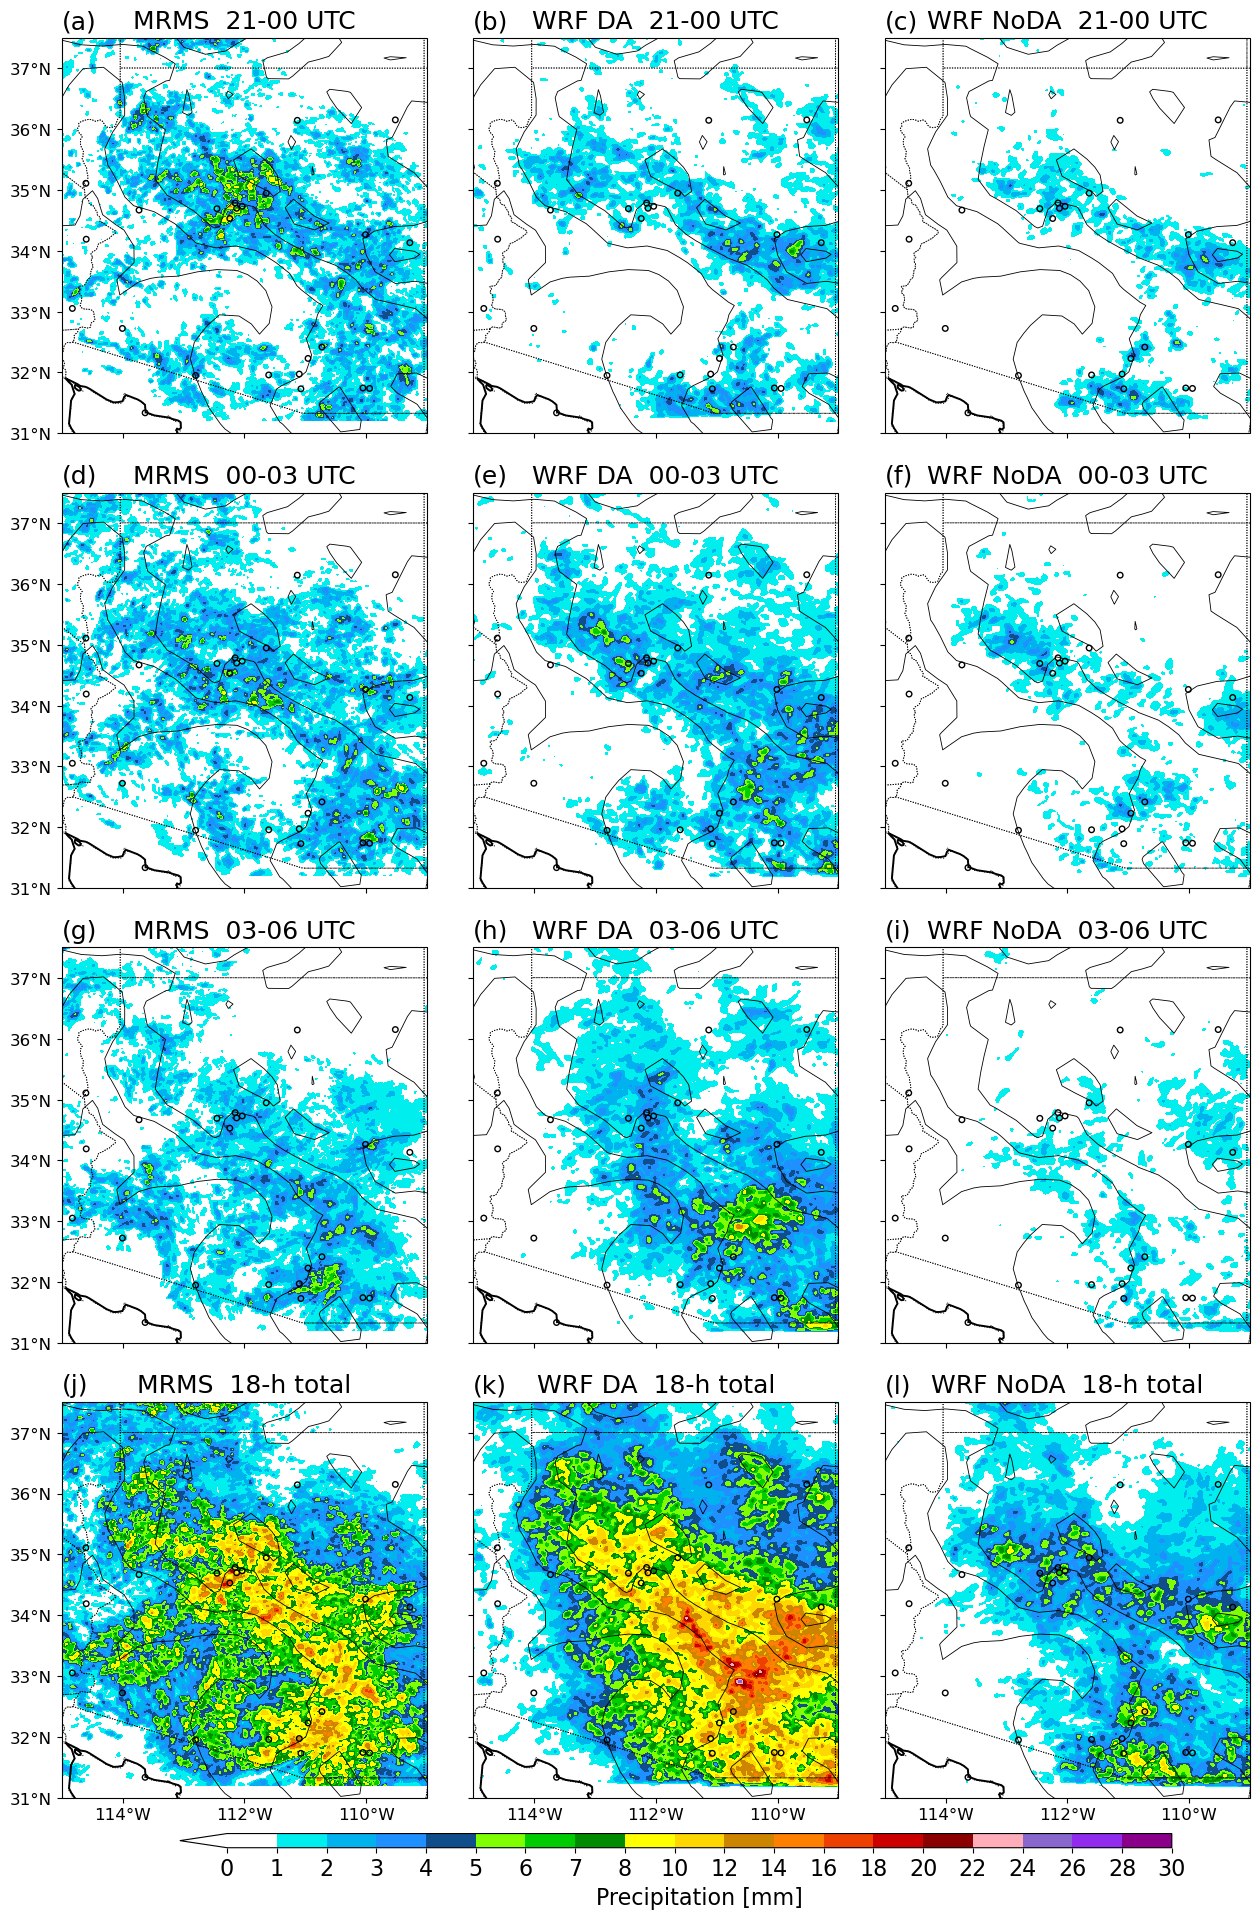

In [15]:
###########################################
# Plot #           
###########################################
peri = [1,2,3]
period = ['21-00','00-03','03-06']
alph = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
projection = ccrs.PlateCarree()
fig, axe = plt.subplots(4, 3, figsize=(16, 22),
                                   subplot_kw={'projection': projection})
## AX1
axlist = axe.flatten()
for ax1 in axlist:
    plot_background(ax1)
    c = 0
    for iperi in peri:
        p0 = axlist[c+0].contourf(Olon,Olat,mut3_pcp[iperi,:,:],
                           var_3hr,cmap=precip_3hr,norm=adjnorm_3hr,extend='min',transform=projection)
        axlist[c+0].set_xticklabels([])
        
        p1 = axlist[c+1].contourf(xlon,xlat,m_dr_as[iperi,:,:],
                           var_3hr,cmap=precip_3hr,norm=adjnorm_3hr,extend='min',transform=projection,)
        axlist[c+1].set_yticklabels([]); axlist[c+1].set_xticklabels([])
        
        p2 = axlist[c+2].contourf(xlon,xlat,m_dr_no[iperi,:,:],
                           var_3hr,cmap=precip_3hr,norm=adjnorm_3hr,extend='min',transform=projection,)
        axlist[c+2].set_yticklabels([]); axlist[c+2].set_xticklabels([])
        
        c = c + 3
      
    p9 = axlist[9].contourf(Olon,Olat,mACC_PCP,
                           var_3hr,cmap=precip_3hr,norm=adjnorm_3hr,extend='min',transform=projection)
    
    p10 = axlist[10].contourf(xlon,xlat,mR_EXP1,
                           var_3hr,cmap=precip_3hr,norm=adjnorm_3hr,extend='min',transform=projection,)
    axlist[10].set_yticklabels([])
    
    p11 = axlist[11].contourf(xlon,xlat,mR_EXP2,
                           var_3hr,cmap=precip_3hr,norm=adjnorm_3hr,extend='min',transform=projection,)
    axlist[11].set_yticklabels([])    

    axlist[0].set_xticklabels([]);axlist[1].set_xticklabels([]);axlist[2].set_xticklabels([])
    
    ## set title
    c = 0
    for ip in period:
        axlist[c+0].set_title('MRMS  '+f'{ip}'+' UTC',
                            loc='center',pad=7,fontsize=18)
        axlist[c+1].set_title('WRF DA  '+f'{ip}'+' UTC' ,
                            loc='center',pad=7,fontsize=18)
        axlist[c+2].set_title('WRF NoDA  '+f'{ip}'+' UTC',
                            loc='center',pad=7,fontsize=18)
        c = c + 3
    axlist[9].set_title('MRMS  18-h total',
                            loc='center',pad=7,fontsize=18)
    axlist[10].set_title('WRF DA  18-h total',
                            loc='center',pad=7,fontsize=18)
    axlist[11].set_title('WRF NoDA  18-h total',
                            loc='center',pad=7,fontsize=18)
    
    for ip in range(len(alph)):
        axlist[ip].set_title(alph[ip],loc='left',pad=7,fontsize=18)
        
    ## obs
    for iob in range(12):
        s0 = axlist[iob].scatter(Oblon,Oblat,s=16,edgecolor='k')
        s0.set_facecolor('none')
    
#Add precip colorbar
cbar0 = fig.colorbar(p0,ticks=var_3hr,ax=axe,orientation='horizontal',
                    shrink=0.8,aspect=70,pad=-0.01,anchor=(0.5,-0.3))
cbar0.ax.tick_params(labelsize=16)
cbar0.set_label('Precipitation [mm]',fontsize=16)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=-0.1, 
                    hspace= 0.15)

## SAVE
dir_out = '/secchi/bayu/PLOTS/ARIZONA_PRO/RAINNC/'
plotfile  = 'MEAN_RAIN-21-00-03-T_DA-NODA-MRMS.png'
sf = fig.savefig(dir_out+plotfile, dpi=300, bbox_inches='tight')

## CLOSE
plt.show()
plt.close()